In [1]:
!pip install scikit-learn
!pip install torchbnn

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchbnn as bnn
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader

# Make Moons 데이터 생성
X, y = make_moons(n_samples=1000, noise=0.2, random_state=42)

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 데이터를 Tensor로 변환
X_train = torch.Tensor(X_train)
y_train = torch.Tensor(y_train).long()
X_test = torch.Tensor(X_test)
y_test = torch.Tensor(y_test).long()

# 데이터셋 생성
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

# 데이터 로더 설정
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 모델 생성
class BayesianNetwork(nn.Module):
    def __init__(self):
        super(BayesianNetwork, self).__init__()

        self.fc1 = bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=2, out_features=16)
        self.fc2 = bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=16, out_features=2)

    def forward(self, x):
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.fc2(x)
        return x

# 모델 생성
model = BayesianNetwork()

# 손실 함수 및 최적화 알고리즘 설정
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 학습
num_epochs = 10
for epoch in range(num_epochs):
    # 모델을 학습 모드로 설정
    model.train()

    for images, labels in train_loader:
        # Forward 연산
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward 연산 및 경사하강법
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # 매 에폭마다 정확도 출력
    with torch.no_grad():
        # 모델을 평가 모드로 설정
        model.eval()

        total = 0
        correct = 0

        for images, labels in test_loader:
            # 모델 예측
            outputs = model(images)

            # 예측 결과를 가져오기 위해 확률값을 로그 확률로 변환
            _, predicted = torch.max(outputs.data, 1)

            # 전체 데이터 개수 업데이트
            total += labels.size(0)

            # 정확하게 예측한 데이터 개수 업데이트
            correct += (predicted == labels).sum().item()

        # 정확도 계산
        accuracy = 100 * correct / total

        # 정확도 출력
        print('Accuracy on the test set: {:.2f}%'.format(accuracy))


Accuracy on the test set: 66.00%
Accuracy on the test set: 73.00%
Accuracy on the test set: 82.50%
Accuracy on the test set: 86.00%
Accuracy on the test set: 73.50%
Accuracy on the test set: 71.00%
Accuracy on the test set: 81.00%
Accuracy on the test set: 82.50%
Accuracy on the test set: 81.00%
Accuracy on the test set: 82.00%


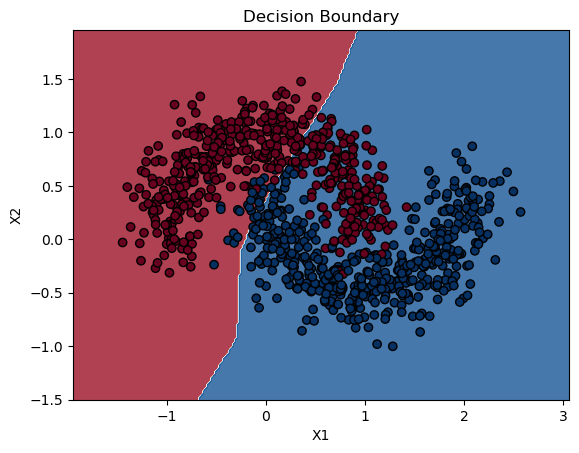

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# 데이터셋의 범위 설정
x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                     np.arange(y_min, y_max, 0.02))

# Meshgrid를 텐서로 변환
grid_tensor = torch.Tensor(np.c_[xx.ravel(), yy.ravel()])

# 모델을 평가 모드로 설정
model.eval()

# 예측값 계산
with torch.no_grad():
    grid_outputs = model(grid_tensor)
    _, grid_predicted = torch.max(grid_outputs, 1)

# 예측 결과를 플롯으로 표시
grid_predicted = grid_predicted.view(xx.shape)
plt.contourf(xx, yy, grid_predicted, cmap=plt.cm.RdBu, alpha=0.8)

# 원본 데이터 플롯
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdBu, edgecolors='k')

# 플롯 설정
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xlabel('X1')
plt.ylabel('X2')
plt.title('Decision Boundary')
plt.show()
